# AIChE presentation

This is the code that the November 2023 AIChE presentation is based on. 

Not everything in this notebook made it into the presentation. 

The code also contains type annotations that where removed from the presentation.

## First import standard libraries that are needed

In [1]:
from typing import Callable

import numpy as np
import pandas as pd
import attrs
import seaborn as sns
from scipy.constants import g

from matplotlib import pyplot as plt
%matplotlib inline

from gumps.studies.study import SimpleSimulationStudy
from gumps.common.parallel import MultiprocessParallel
from gumps.studies.batch_study import BatchStudyMultiProcess, AbstractBatchStudy
from gumps.apps.sensitivity import SensitivityApp
from gumps.solvers.sensitivity import SensitivitySolverParameters
from gumps.interface import model_interface
from gumps.interface import model_units
import gumps.apps.response_surface

/tmp/ipykernel_19315/2250836836.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## For this presentation simple projectile motion is used where the distance and flight time are calculated for a given speed and angle.

Distance = Speed^2 * sin(2 * Angle)/Gravity

FlightTime = 2 * Speed * sin(Angle)/Gravity

In [2]:
@attrs.define
class ProjectileState:
    speed: float
    launch_angle: float
    distance: float = 0
    flight_time: float = 0

class Projectile(gumps.kernels.kernel.AbstractKernel):
    def user_defined_function(self, variables: ProjectileState) -> None:
        "n-sphere function"
        speed = variables.speed
        angle = variables.launch_angle
        variables.distance = speed**2 * np.sin(2*angle) / g
        variables.flight_time = 2 * speed * np.sin(angle) / g

    def get_state_class(self) -> ProjectileState:
        return ProjectileState

## Everything is based on interfaces so lets create a Study from this kernel, in this case no complicated solver is needed

In [3]:
kernel = Projectile()

problem = {'speed': 5, 'launch_angle': np.pi/4}

study = SimpleSimulationStudy(problem=problem, 
                    kernel=kernel)

In [4]:
result = study.run()
print(result)

print(result.distance)

ProjectileState(speed=5, launch_angle=0.7853981633974483, distance=2.5492905324448207, flight_time=0.7210482490825588)
2.5492905324448207


## Now that we have a Study we can create a Batch interface for this study that can run the study in parallel

# 

In [5]:
parallel = MultiprocessParallel(poolsize=4)

batch_parallel = BatchStudyMultiProcess(study=study, 
                        parallel=parallel)

In [6]:
input_data = pd.DataFrame({'speed':np.linspace(0, 1, 5),
                            'launch_angle':np.linspace(0, np.pi/2, 5)})

def processing_function_single(input_data: pd.DataFrame) -> pd.Series:
    return pd.Series({'distance':input_data['distance'].values[0],
                      'flight_time':input_data['flight_time'].values[0]})

batch_parallel.run(input_data=input_data, 
                        processing_function=processing_function_single)

,distance,flight_time
0,0.000000e+00,0.000000
1,4.506552e-03,0.019511
2,2.549291e-02,0.072105
3,4.055896e-02,0.141314
4,1.248792e-17,0.203943


## We could also just directly implement a Batch interface for projectile motion which is especially useful when working with neural networks

In [7]:
class BatchProjectile(AbstractBatchStudy):
    def run(self, input_data:pd.DataFrame, processing_function:Callable):
        "run the batch simulation"
        speed = input_data['speed']
        launch_angle = input_data['launch_angle']
        distance = speed**2 * np.sin(2*launch_angle) / g
        flight_time = 2 * speed * np.sin(launch_angle) / g

        output_data = pd.DataFrame({'distance': distance,
                            'flight_time': flight_time})

        self.save_results(input_data, output_data)

        return processing_function(output_data)

In [8]:
batch = BatchProjectile()

def processing_function(input_data: pd.DataFrame):
    return input_data

batch.run(input_data=input_data,
    processing_function=processing_function)

,distance,flight_time
0,0.000000e+00,0.000000
1,4.506552e-03,0.019511
2,2.549291e-02,0.072105
3,4.055896e-02,0.141314
4,1.248792e-17,0.203943


## Now that we have a batch interface we can use it, first lets look at what this model looks like

In [9]:
from gumps.solvers.response_sampler import ResponseSamplerParameters
from gumps.apps.response_surface import ResponseSurface

bs = pd.Series({'speed':25, 'launch_angle':np.pi/4})
lb = pd.Series({'speed':0, 'launch_angle':0})
ub = pd.Series({'speed':50, 'launch_angle':np.pi/2})

config = ResponseSamplerParameters(lower_bound=lb,
                                upper_bound=ub,
                                baseline = bs,
                                points_1d=49,
                                points_2d_per_dimension=7,)


app = ResponseSurface(parameters=config,
                    batch=batch,
                    processing_function=processing_function,
                    parallel=parallel)

In [10]:
app.run()

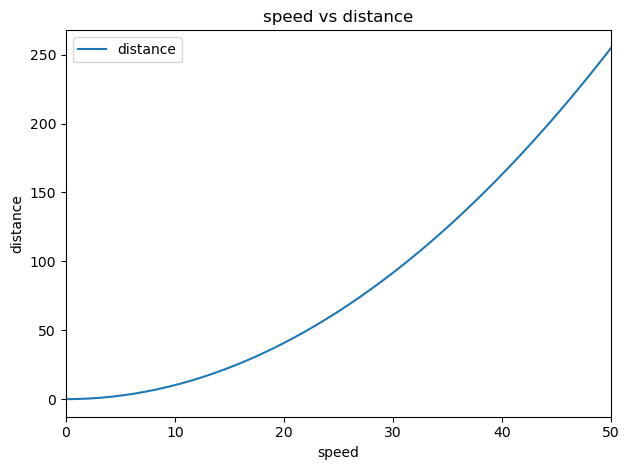

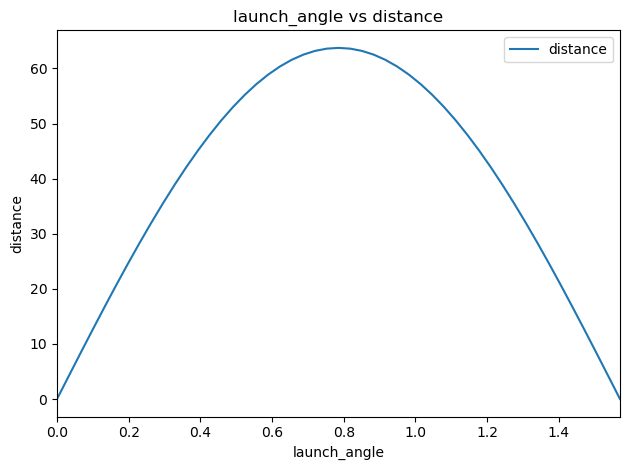

In [11]:
app.show_1d_plots('distance')

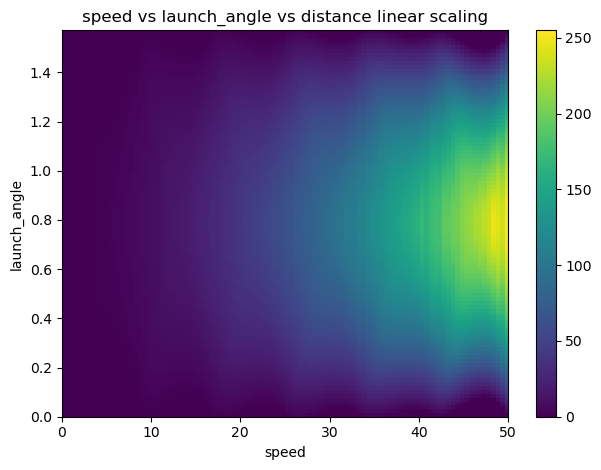

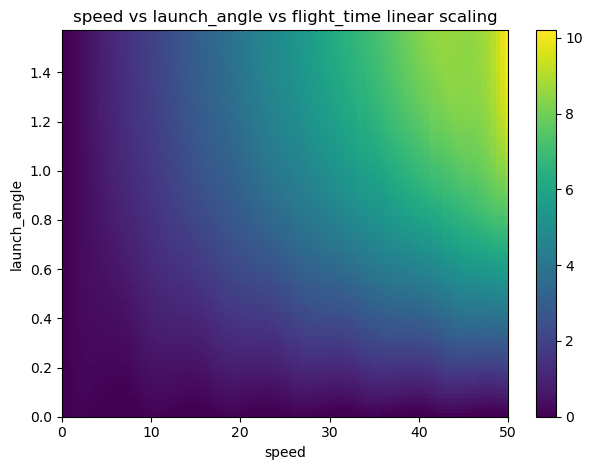

In [12]:
app.show_2d_plots('distance', show_points=False)

app.show_2d_plots('flight_time', show_points=False)

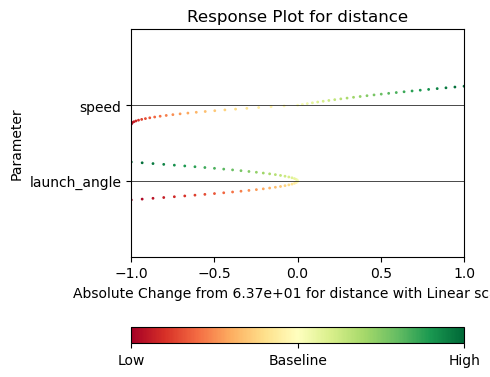

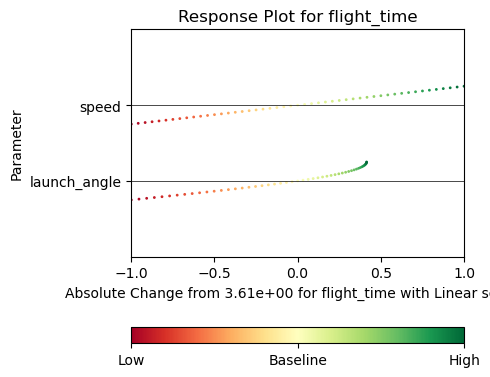

In [13]:
app.show_tornado_plot('distance')
app.show_tornado_plot('flight_time')

## Lets look at a sensitivity analysis

In [14]:
parameters = SensitivitySolverParameters(lower_bound=lb,
                                        upper_bound=ub,
                                        sample_power=16)

def get_distance(input_data: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame({'distance':input_data['distance']})

app = SensitivityApp(parameters=parameters,
                    processing_function=get_distance,
                    directory=None,
                    batch=batch)

In [15]:
app.run()

In [16]:
app.results()

{'ST':                     ST   ST_conf
 speed         0.808546  0.009081
 launch_angle  0.344617  0.006827,
 'S1':                     S1   S1_conf
 speed         0.655381  0.009217
 launch_angle  0.191455  0.005906,
 'S2':                              S2   S2_conf
 [speed, launch_angle]  0.153165  0.014845}

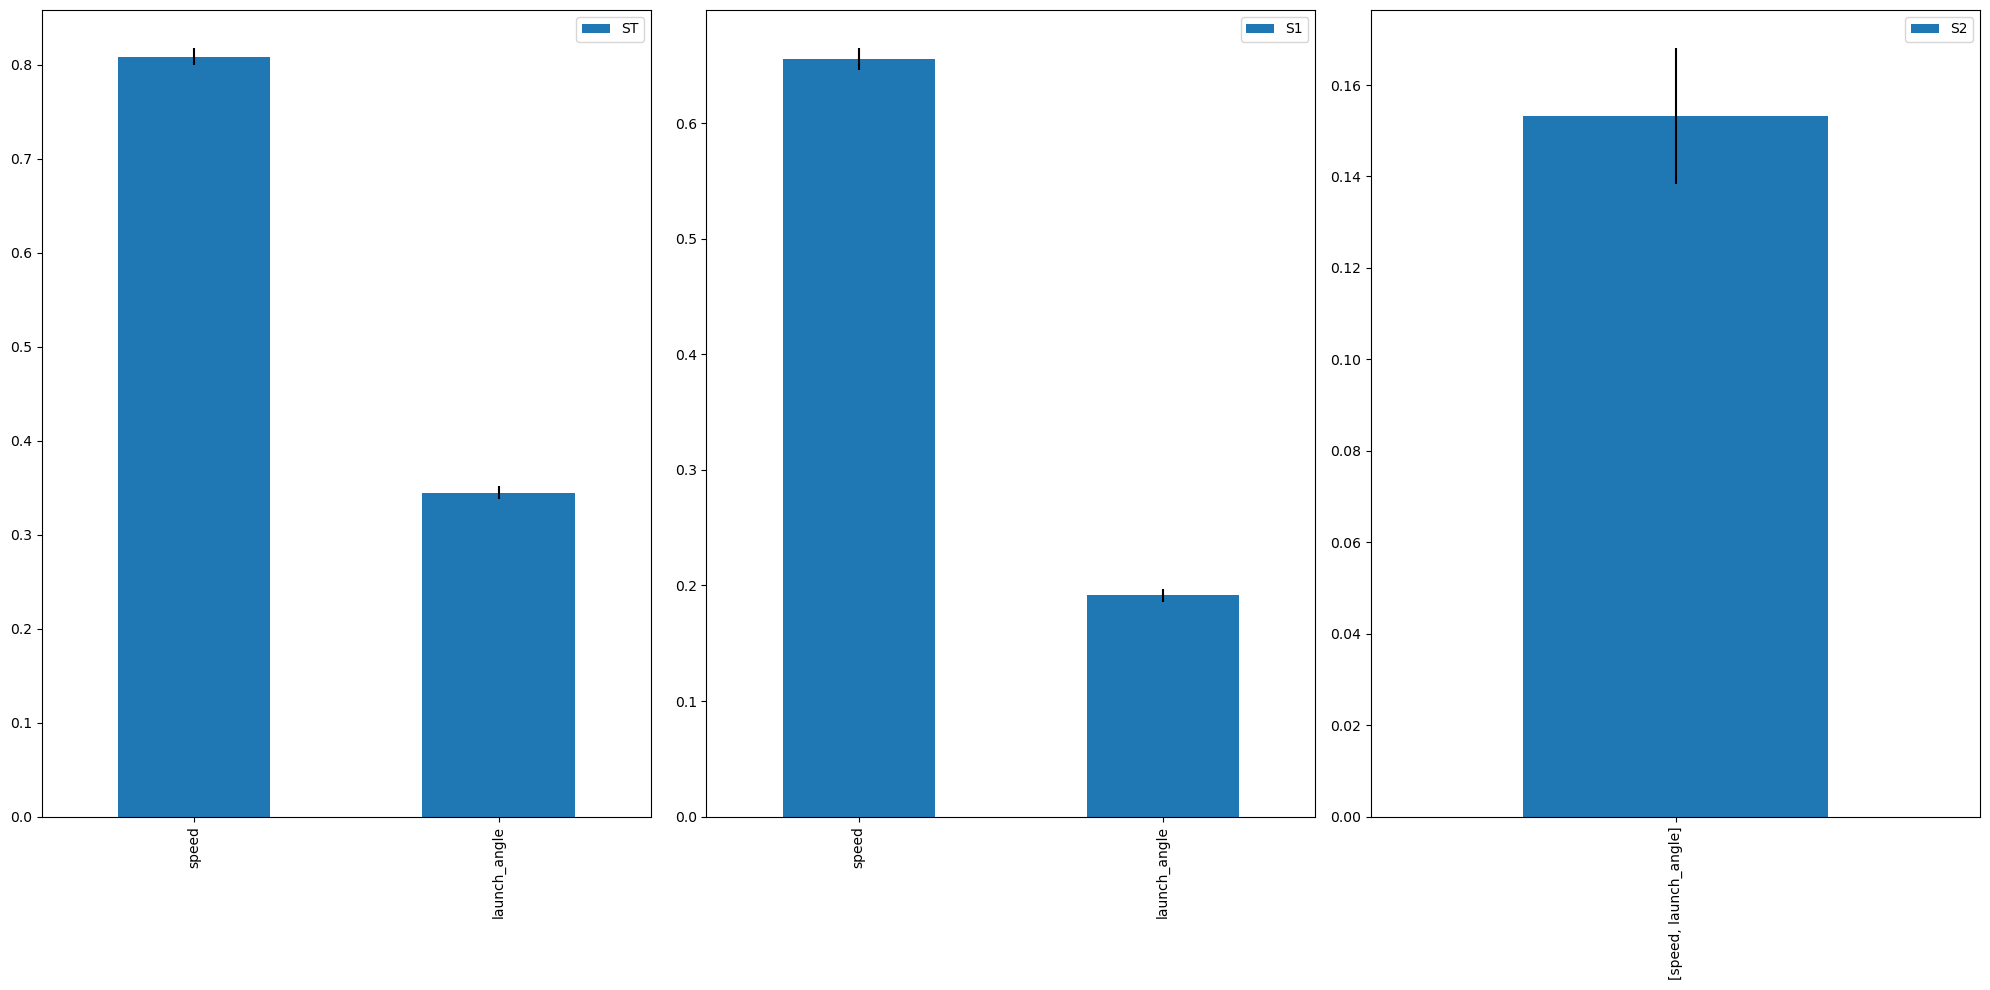

In [17]:
app.plot()
plt.gcf().set_size_inches(20, 10)
plt.tight_layout()

## Lets look at a Monte Carlo simulation and see what the distribution of flight times and distances looks like

In [18]:
import scipy.stats
from gumps.solvers.monte_carlo_solver import MonteCarloParameters
from gumps.apps.monte_carlo import MonteCarloApp

distributions = {
        'speed': scipy.stats.uniform(0, 50),
        'launch_angle': scipy.stats.uniform(0, np.pi/2)
    }

parameters = MonteCarloParameters(
    variable_distributions=distributions,
    target_probability=[0.05, 0.5, 0.95],
    tolerance=1e-2,
    runnable_batch_size=4096,
    sampler_scramble=False)

mc_app = MonteCarloApp(parameters=parameters,
    processing_function=processing_function,
    directory=None,
    batch=batch)

In [19]:
mc_app.run()

/home/wheymann/mambaforge/envs/gumps_311/lib/python3.11/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(
/home/wheymann/GUMPS/gumps/apps/monte_carlo.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


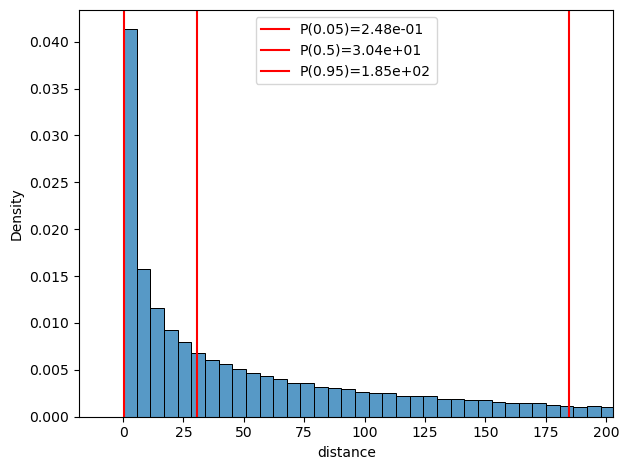

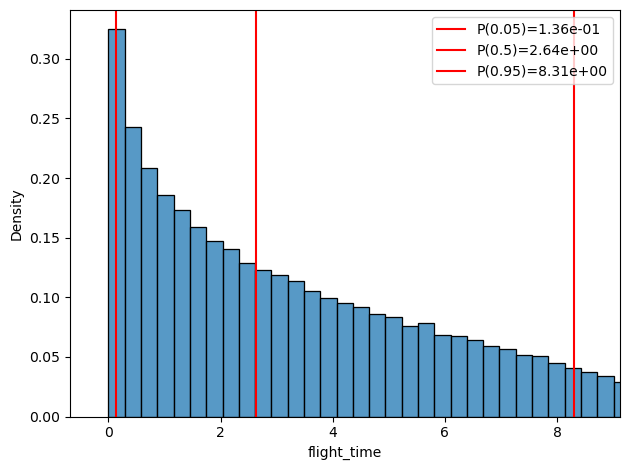

<Figure size 640x480 with 0 Axes>

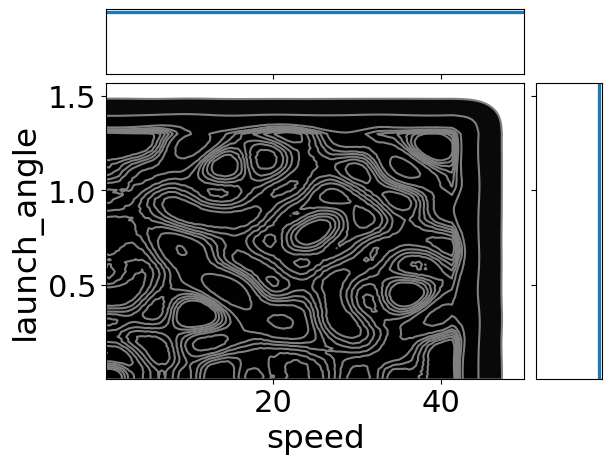

In [20]:
%matplotlib inline
a = mc_app.create_plots()

In [21]:
mc_app.answer()

distance_0.05         0.248062
flight_time_0.05      0.136137
distance_0.5         30.419999
flight_time_0.5       2.635288
distance_0.95       184.533282
flight_time_0.95      8.305188
dtype: float64

## Lets build a regression model for this system. The first thing we need to do is sample the data

In [22]:
from gumps.apps.parametric_sweep import ParametricSweepApp
from gumps.solvers.sampler import SamplerSolverParameters

sampler_parameters = SamplerSolverParameters(
    number_of_samples = 8,
    lower_bound = {'speed':0, 'launch_angle':0},
    upper_bound = {'speed':50, 'launch_angle':np.pi/2},
    sampler = "sobol"
    )

sampler_app = ParametricSweepApp(parameters=sampler_parameters,
        processing_function=processing_function,
        directory=None,
        batch=batch)
sampler_app.run()

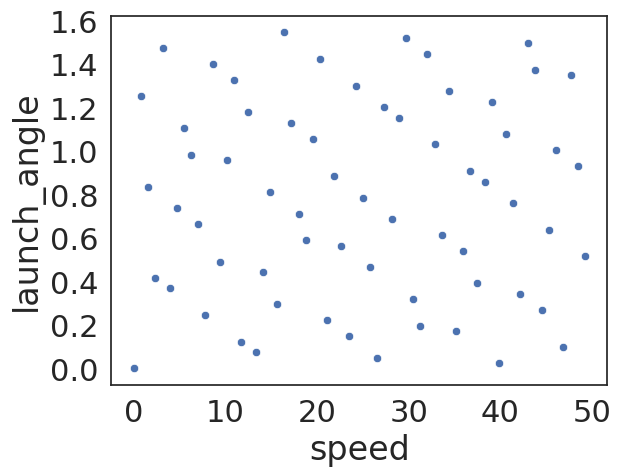

In [23]:
#create a version of the sampler with more points as a visualization for the presentation
parameters_plot = SamplerSolverParameters(
    number_of_samples = 64,
    lower_bound = {'speed':0, 'launch_angle':0},
    upper_bound = {'speed':50, 'launch_angle':np.pi/2},
    sampler = "sobol"
    )

app_plot = ParametricSweepApp(parameters=parameters_plot,
        processing_function=processing_function,
        directory=None,
        batch=batch)

app_plot.run()

sns.set_theme(style="white", font_scale=2)
sns.scatterplot(x='speed', y='launch_angle', data=app_plot.factors)
plt.plot()

sns.set_theme(style="white", font_scale=1)

## Lets build a gaussian process regression from this data

Error: 0.9996824909056092


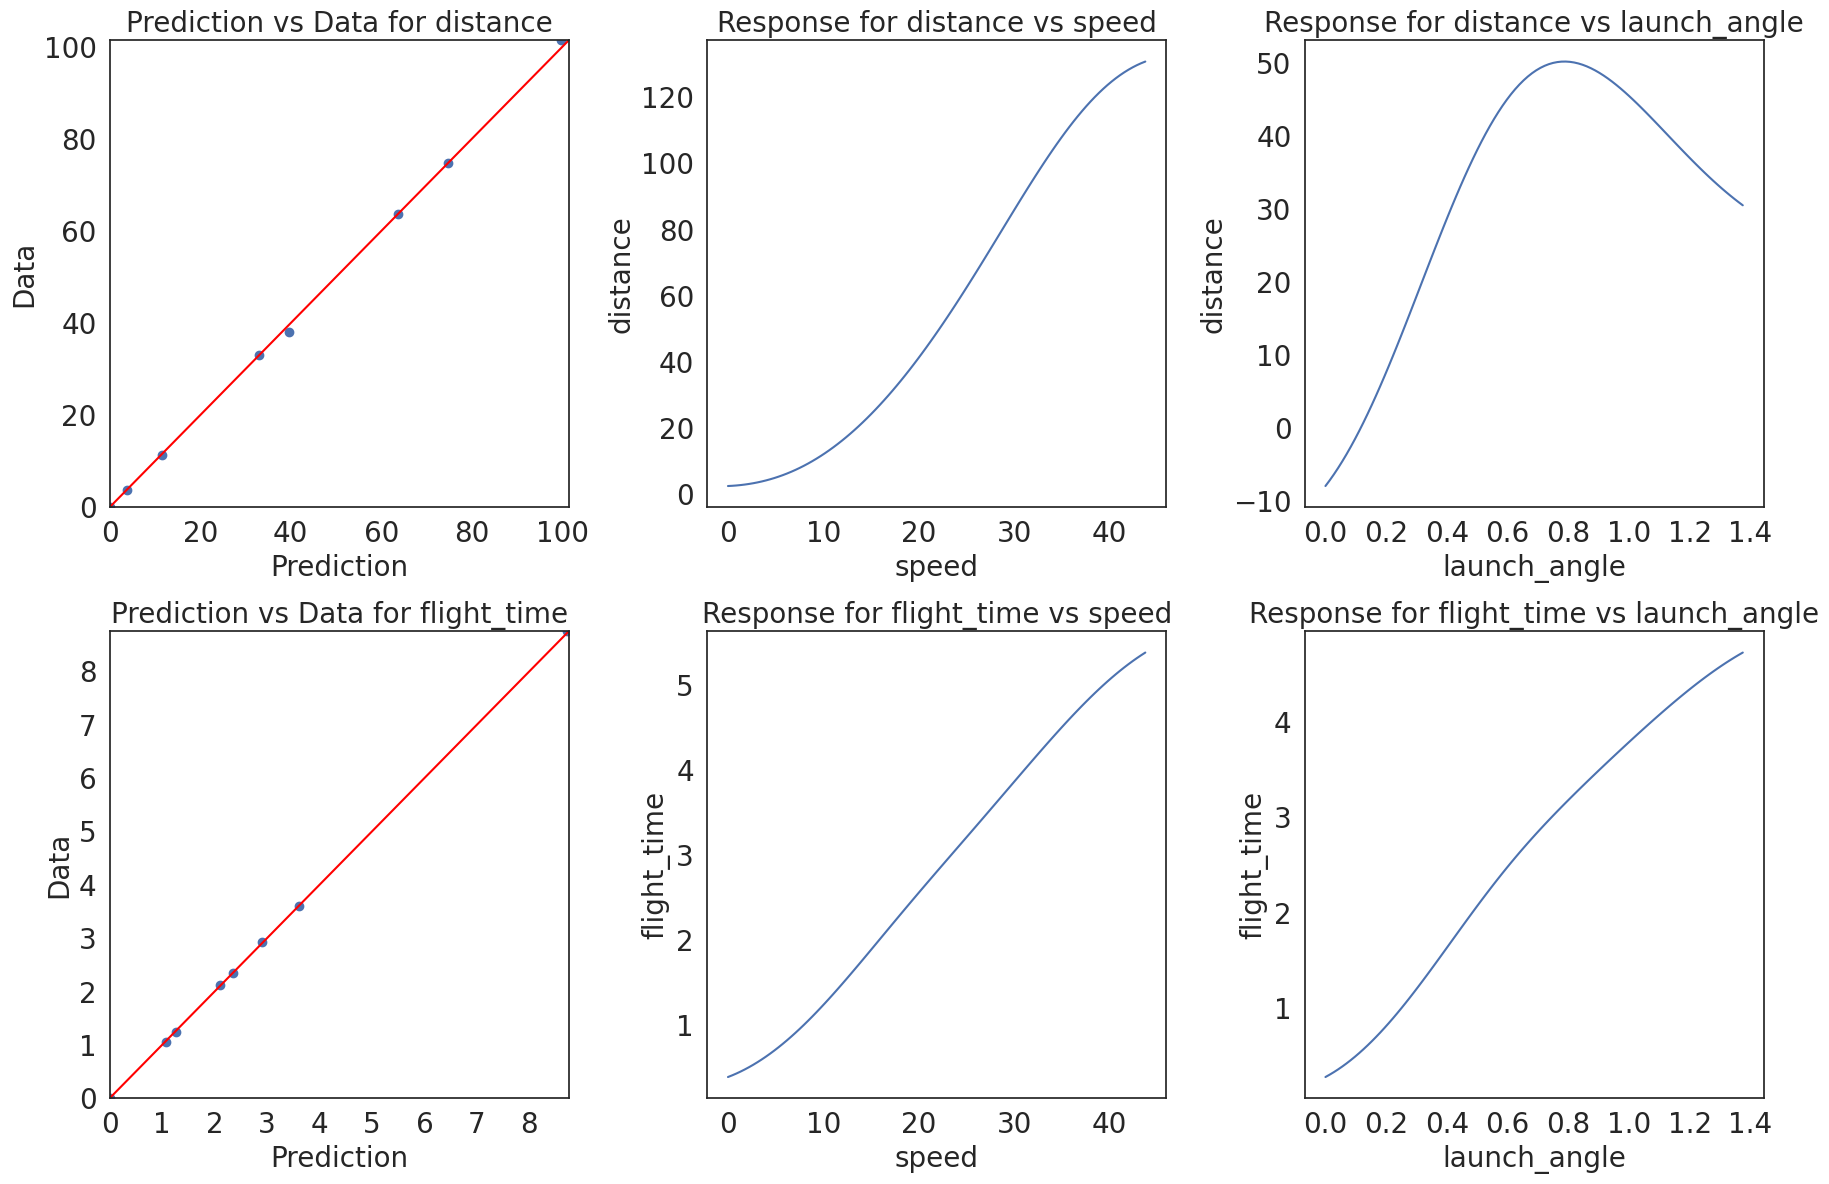

In [24]:
from gumps.solvers.regressors.gaussian_regressor import GaussianRegressor
from gumps.solvers.regressors.regression_solver import RegressionParameters
from gumps.graph.regressor import RegressorPlotParameters, RegressorPlot

reg_data = RegressionParameters(input_data=sampler_app.factors,
                                output_data=sampler_app.responses)

regressor = GaussianRegressor(reg_data)
regressor.fit()



print(f"Error: {regressor.error_metrics()['score']}")

params = RegressorPlotParameters(regressor,
                                 reg_data.input_data.mean(),
                                 reg_data.input_data.min(),
                                 reg_data.input_data.max())

reg_plot = RegressorPlot(params)
reg_plot.plot()

## Lets use the adaptive sampler to add more points to improve the regression

In [25]:
from gumps.apps.adaptive_sampler import AdaptiveSamplerApp, AdaptiveSamplerAppParameters
from gumps.solvers.adaptive_solver import AdaptiveSamplerParameters

sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=50,
    batch_size=10
)

parameters = AdaptiveSamplerAppParameters(
    regressor=regressor,
    sampler_parameters = sampler_parameters
    )

app_sampler = AdaptiveSamplerApp(parameters=parameters,
        batch=batch,
        processing_function=processing_function)
app_sampler.run()

Error: 0.9999998668943864


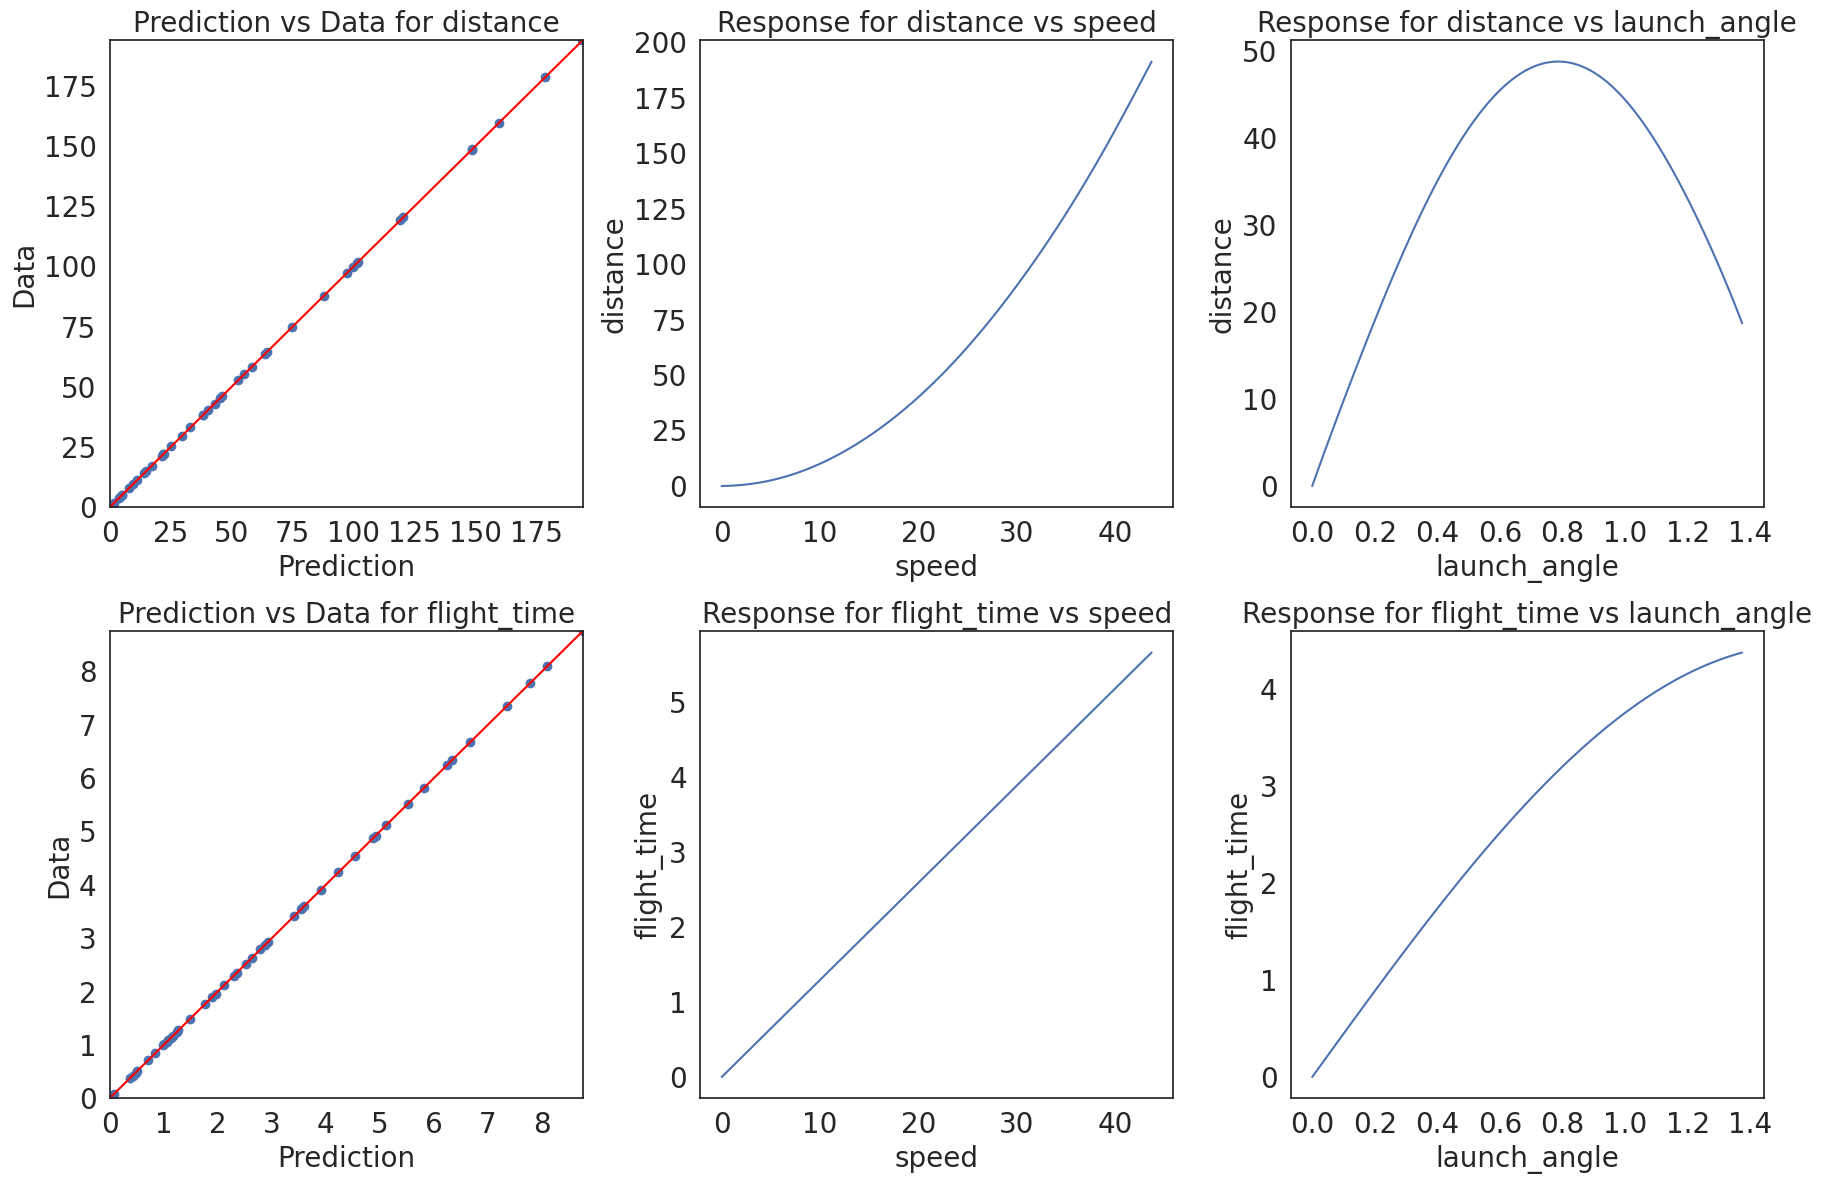

In [26]:
params = RegressorPlotParameters(regressor, reg_data.input_data.mean(),
                                 reg_data.input_data.min(),
                                 reg_data.input_data.max())

print(f"Error: {regressor.error_metrics()['score']}")
reg_plot = RegressorPlot(params)
reg_plot.plot()

## now lets use the regression model to drive calculations

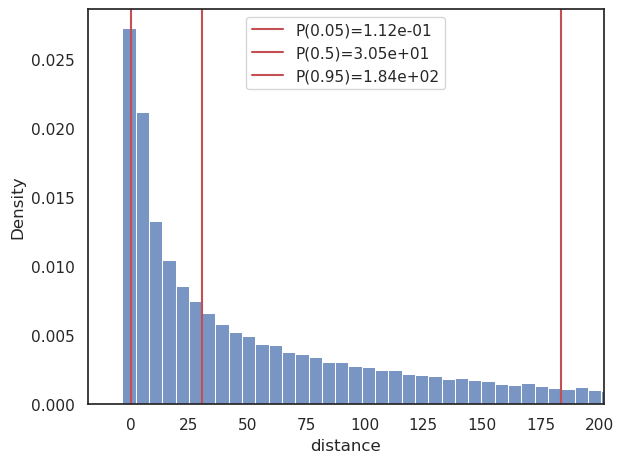

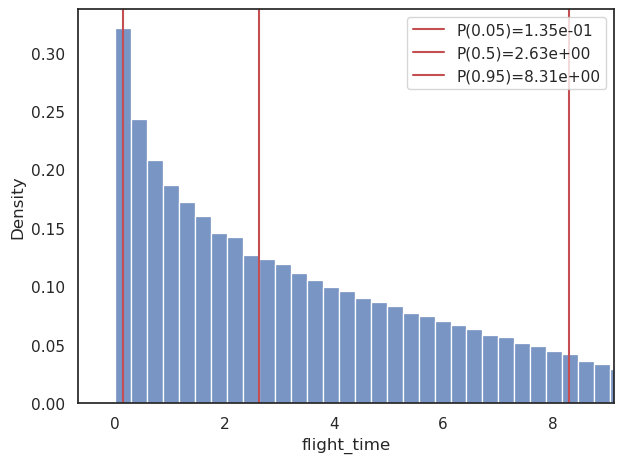

<Figure size 640x480 with 0 Axes>

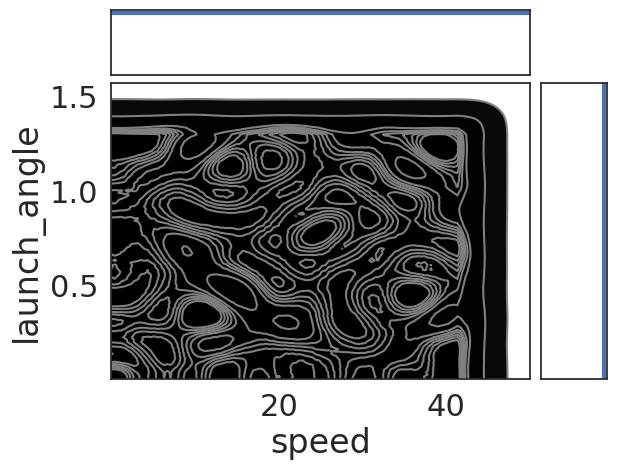

In [27]:
parameters = gumps.solvers.monte_carlo_solver.MonteCarloParameters(variable_distributions=distributions,
        target_probability=[0.05, 0.5, 0.95],
        tolerance=1e-2,
        runnable_batch_size=4096,
        sampler_scramble=False)

mc_app_surrogate = MonteCarloApp(parameters=parameters,
    processing_function=processing_function, directory=None,
    batch=regressor)

mc_app_surrogate.run()

%matplotlib inline
a = mc_app_surrogate.create_plots()

Text(0.5, 0, 'Distance (m)')

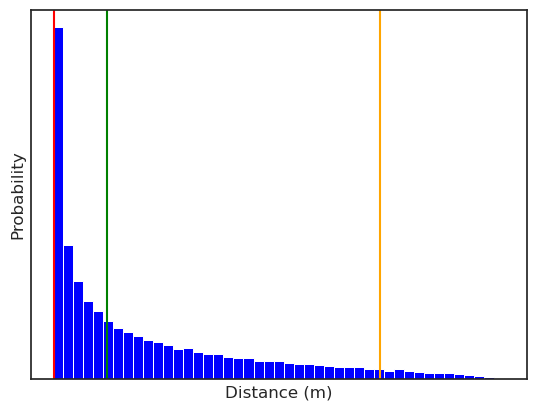

In [28]:
answer = mc_app.answer()

data = pd.DataFrame({'original':mc_app.scores['distance']})

edges = np.histogram_bin_edges(data['original'], bins="auto")

sns.histplot(data=data, x='original', stat='probability', color='blue', label='Original', bins=edges, alpha=1.0)
plt.axvline(answer['distance_0.05'], color='red', label='5%')
plt.axvline(answer['distance_0.5'], color='green', label='50%')
plt.axvline(answer['distance_0.95'], color='orange', label='95%')
#plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel('Distance (m)')

Text(0.5, 0, 'Flight Time (s)')

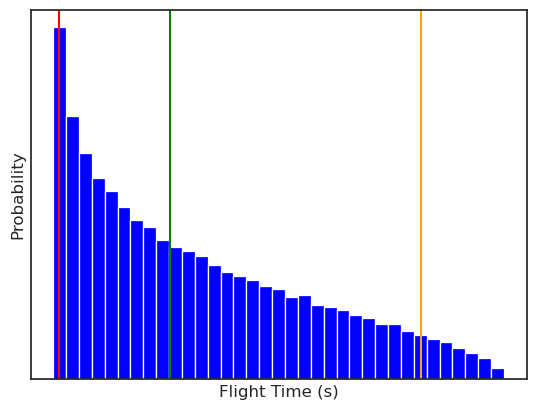

In [29]:
answer = mc_app.answer()

data = pd.DataFrame({'original':mc_app.scores['flight_time']})

edges = np.histogram_bin_edges(data['original'], bins="auto")

sns.histplot(data=data, x='original', stat='probability', color='blue', label='Original', bins=edges, alpha=1.0)
plt.axvline(answer['flight_time_0.05'], color='red', label='5%')
plt.axvline(answer['flight_time_0.5'], color='green', label='50%')
plt.axvline(answer['flight_time_0.95'], color='orange', label='95%')
#plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel('Flight Time (s)')

In [30]:
config = gumps.solvers.response_sampler.ResponseSamplerParameters(lower_bound=lb,
                                                                  upper_bound=ub,
                                                                  baseline = bs,
                                                                  points_1d=49*7,
                                                                  points_2d_per_dimension=7*7,)


app = gumps.apps.response_surface.ResponseSurface(parameters=config,
                                                  batch=regressor,
                                                  processing_function=processing_function,
                                                  parallel=parallel)

In [31]:
app.run()

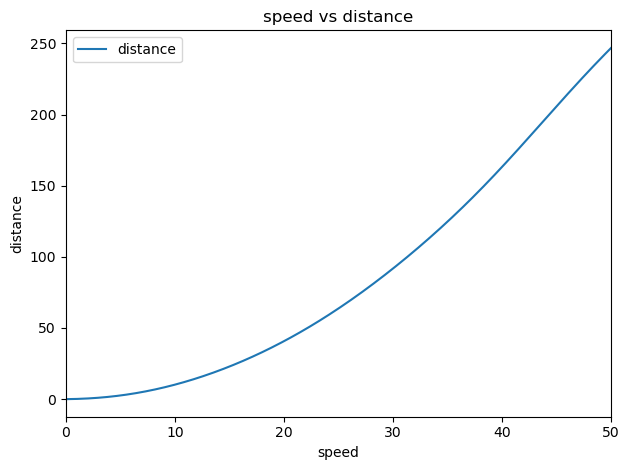

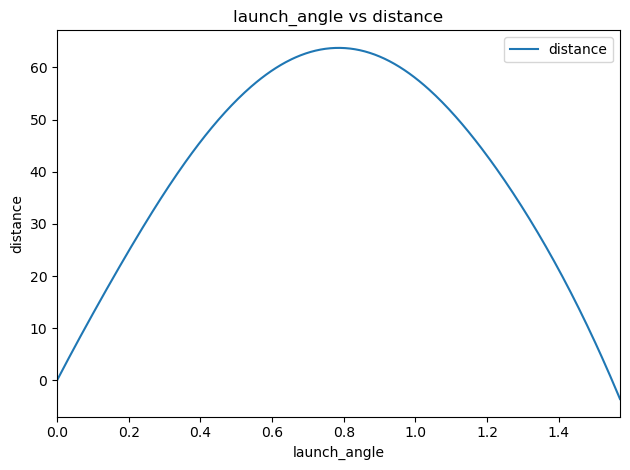

In [32]:
app.show_1d_plots('distance')

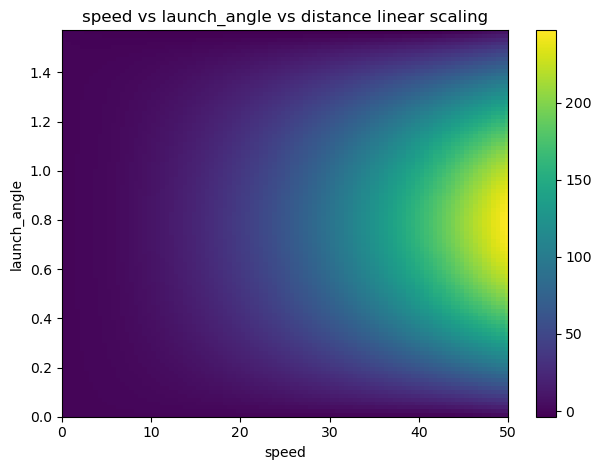

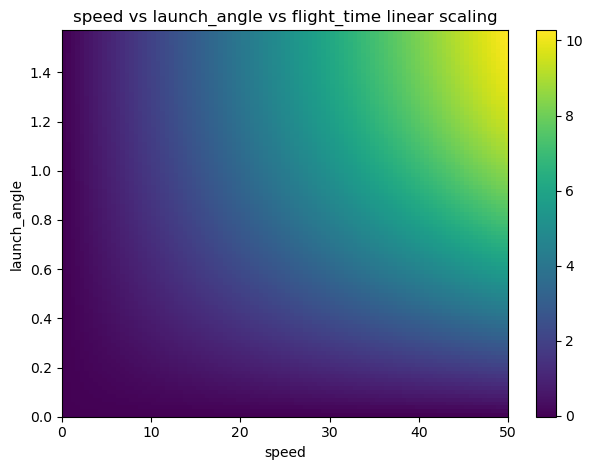

In [33]:
app.show_2d_plots('distance', show_points=False)

app.show_2d_plots('flight_time', show_points=False)

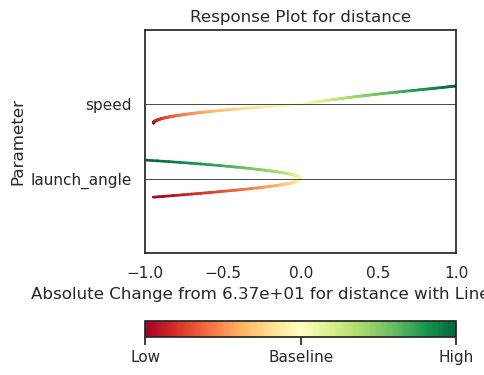

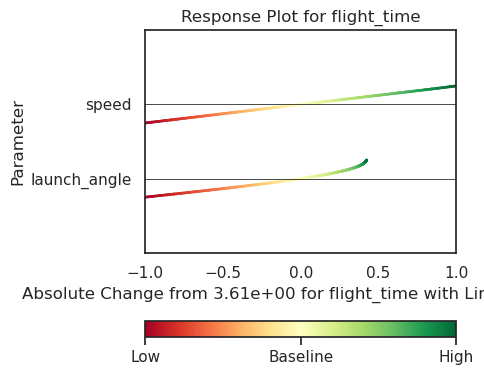

In [34]:
app.show_tornado_plot('distance')
app.show_tornado_plot('flight_time')

## Create a simple model. For this we will use basic projectile motion where we have an initial speed and an angle.

In [35]:
@attrs.define
class Speed(model_units.Speed):
    @classmethod
    def bounds_units(cls):
        return 'meters/second'

    @classmethod
    def lower_bound(cls) -> float|int:
        return 0.0

    @classmethod
    def upper_bound(cls) -> float|int:
        return 50.0


@attrs.define
class LaunchAngle(model_units.Angle):
    @classmethod
    def bounds_units(cls):
        return 'degrees'

    @classmethod
    def lower_bound(cls) -> float|int:
        return 0.0

    @classmethod
    def upper_bound(cls) -> float|int:
        return 90.0


@attrs.define
class FlightTime(model_units.Time):
    @classmethod
    def bounds_units(cls):
        return 'seconds'

    @classmethod
    def lower_bound(cls) -> float|int:
        return 0.0

    @classmethod
    def upper_bound(cls) -> float|int:
        return 20.0

@attrs.define
class Distance(model_units.Length):
    @classmethod
    def bounds_units(cls):
        return 'meters'

    @classmethod
    def lower_bound(cls) -> float|int:
        return 0.0

    @classmethod
    def upper_bound(cls) -> float|int:
        return 3000.0

@attrs.define
class InputModel(model_interface.UnitCollection):
    speed: Speed
    launch_angle: LaunchAngle

@attrs.define
class OutputModel(model_interface.UnitCollection):
    distance: Distance
    flight_time: FlightTime

In [36]:
input_data = InputModel(speed=Speed(100, 'miles/hour'), 
                        launch_angle=LaunchAngle(45, 'degrees'))

print(input_data)

InputModel(speed=Speed(value=100, units=<Quantity(1.0, 'mile / hour')>), launch_angle=LaunchAngle(value=45, units=<Quantity(1, 'degree')>))


In [37]:
def launch(study, input_data: InputModel) -> OutputModel:
    converted = input_data.convert({Speed: 'meters/second', LaunchAngle: 'radians'})
    output_data = study.run_data(data=converted.get_series())
    return OutputModel(distance=Distance(output_data['distance'][0], 'meters'),
                       flight_time=FlightTime(output_data['flight_time'][0], 'seconds'))

In [38]:
output = launch(study, input_data)

converted_output = output.convert({Distance: 'feet', 
                                   FlightTime: 'minutes'})
print(converted_output)
print(f"Distance: {converted_output.distance.value} {converted_output.distance.units} in {converted_output.flight_time.value} {converted_output.flight_time.units}")

OutputModel(distance=Distance(value=668.5857725794914, units=<Quantity(1, 'foot')>), flight_time=FlightTime(value=0.1074458030899557, units=<Quantity(1, 'minute')>))
Distance: 668.5857725794914 1 foot in 0.1074458030899557 1 minute


In [39]:
input_data.get_series()

speed           100
launch_angle     45
dtype: int64

## Generate some graphics used in the presentation

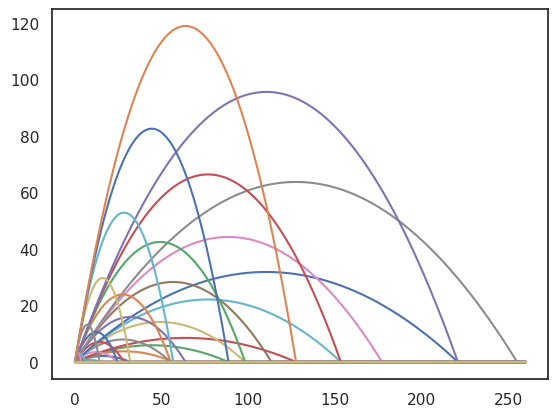

In [40]:
#Create a plot of many different launch angles and speeds

speeds = np.linspace(0, 50, 7)
launch_angles = np.linspace(0, np.pi/2, 7)

speeds, launch_angles = np.meshgrid(speeds, launch_angles)

speeds = speeds.flatten()
launch_angles = launch_angles.flatten()


distance = np.linspace(0, 260, 1000)

height = np.tan(launch_angles[:, np.newaxis]) * distance - (g * distance**2) / (2 * speeds**2 * np.cos(launch_angles)**2)[:, np.newaxis]

height[height<0] = 0

plt.plot(distance, height.T)

## Create a 1D regressor for visualization purposes

In [41]:
from gumps.apps.parametric_sweep import ParametricSweepApp
from gumps.solvers.sampler import SamplerSolverParameters

class BatchProjectile1D(AbstractBatchStudy):

    def start(self):
        ...

    def stop(self):
        ...

    def run(self, input_data:pd.DataFrame, processing_function:Callable):
        "run the batch simulation"
        speed = input_data['speed']
        distance = speed**2 * np.sin(2*np.pi/4) / g
        flight_time = 2 * speed * np.sin(np.pi/4) / g

        output_data = pd.DataFrame({'distance': distance,
                            'flight_time': flight_time})

        self.save_results(input_data, output_data)

        return processing_function(output_data)

batch_1d = BatchProjectile1D()

#we are not going to actually use the sampler, this problem is so simple 
#I need to specially choose points to illustrate how adaptive sampling works
sampler_parameters = SamplerSolverParameters(
    number_of_samples = 3,
    lower_bound = {'speed':0},
    upper_bound = {'speed':50},
    sampler = "latin"
    )

sampler_app = ParametricSweepApp(parameters=sampler_parameters,
        processing_function=processing_function,
        directory=None,
        batch=batch_1d)


#manually choose points to show how adaptive sampling works
sampler_app.factors = pd.DataFrame({'speed':[0, 2, 5, 50]})

sampler_app.responses = batch_1d.run(input_data=sampler_app.factors,
    processing_function=processing_function)

Error: 0.9999998664897051


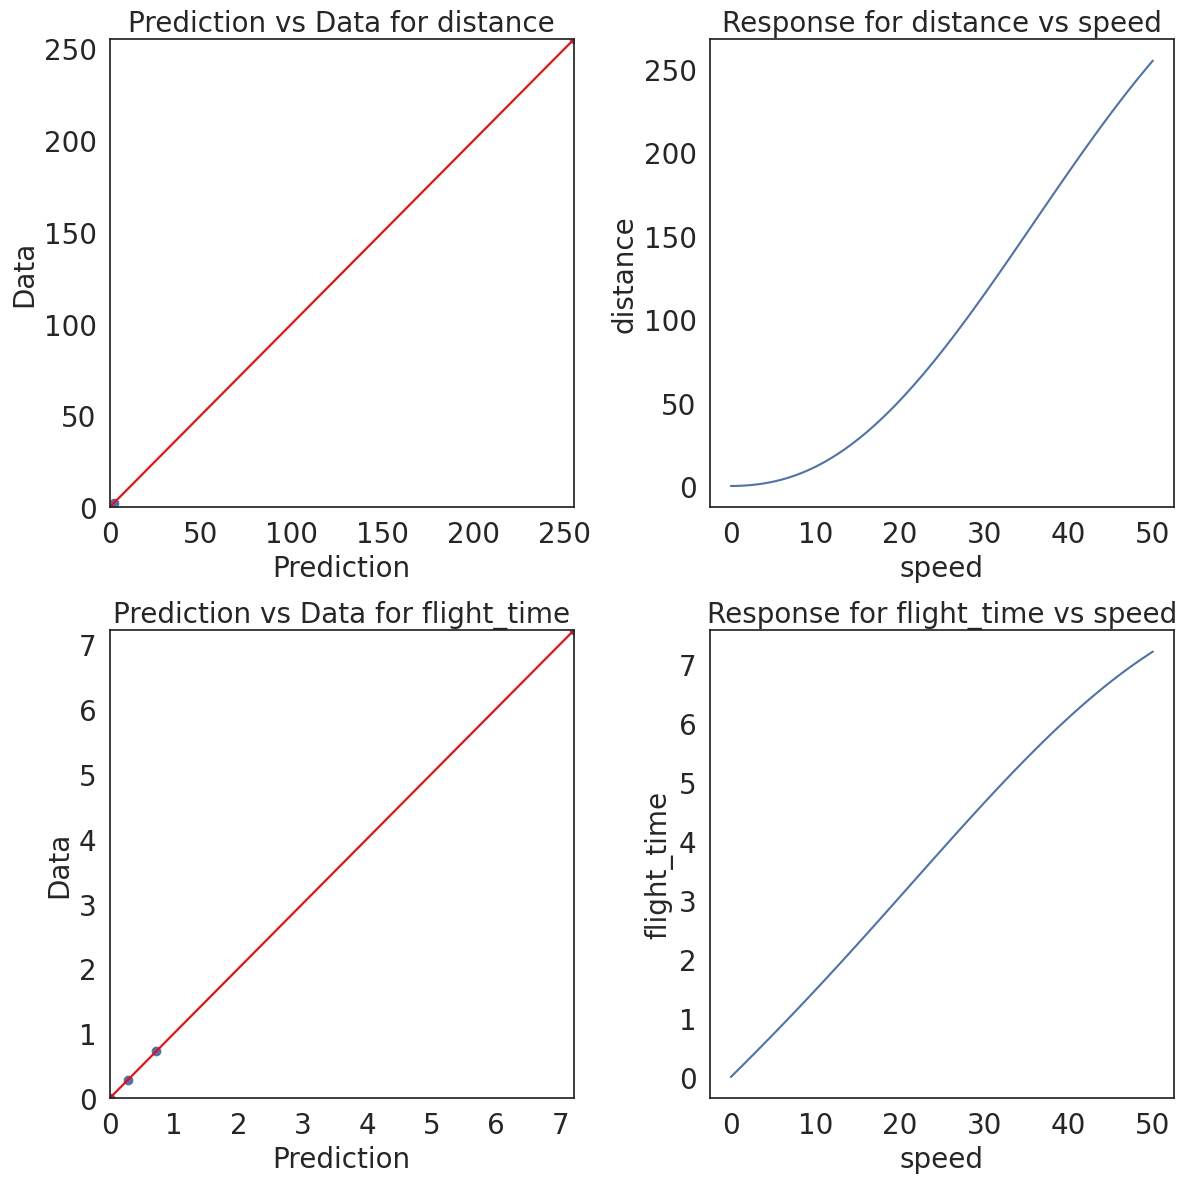

In [42]:
reg_data = RegressionParameters(input_data=sampler_app.factors,
                                output_data=sampler_app.responses)

regressor = GaussianRegressor(reg_data)
regressor.fit()



print(f"Error: {regressor.error_metrics()['score']}")

params = RegressorPlotParameters(regressor,
                                 reg_data.input_data.mean(),
                                 reg_data.input_data.min(),
                                 reg_data.input_data.max())

reg_plot = RegressorPlot(params)
reg_plot.plot()

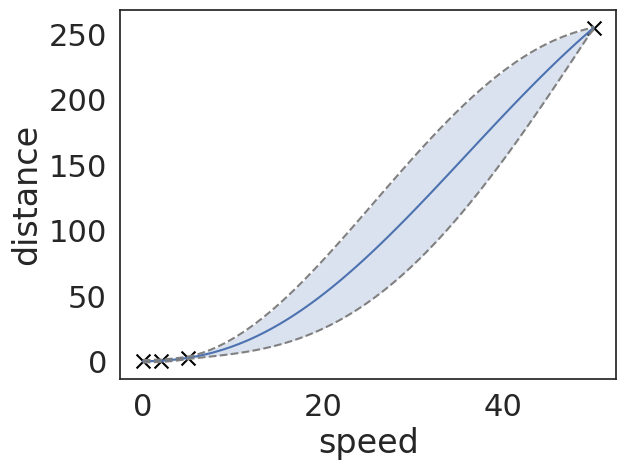

In [43]:
#create a visualization of the guassian process regressor that shows the points and the uncertainty
speeds = np.linspace(0, 50, 100)

input_data = pd.DataFrame({'speed':speeds})


output_data, output_data_std = regressor.predict_uncertainty(input_data)

data = pd.DataFrame({'speed':speeds,
                    'distance':output_data['distance'],
                    'distance_std':output_data_std['distance']})

sns.set_theme(style="white", font_scale=2)
sns.lineplot(x='speed', y='distance', data=data)
plt.scatter(x=sampler_app.factors['speed'], y=sampler_app.responses['distance'], color='black', marker='x', s=100)

#create two lines and fill the area between them
plt.plot(data['speed'], data['distance'] + 2*data['distance_std'], color='grey', linestyle='dashed')
plt.plot(data['speed'], data['distance'] - 2*data['distance_std'], color='grey', linestyle='dashed')
plt.fill_between(data['speed'], data['distance'] + 2*data['distance_std'], data['distance'] - 2*data['distance_std'], alpha=0.2)

In [44]:
sampler_parameters = AdaptiveSamplerParameters(
    points_to_add=8,
    batch_size=1
)

parameters = AdaptiveSamplerAppParameters(
    regressor=regressor,
    sampler_parameters = sampler_parameters
    )

app_sampler = AdaptiveSamplerApp(parameters=parameters,
        batch=batch_1d,
        processing_function=processing_function)
app_sampler.run()

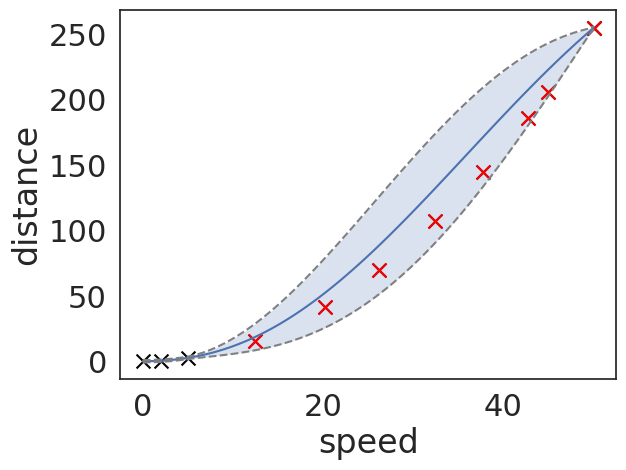

In [45]:
#create a visualization of the adaptive sampler that shows the points and the uncertainty


sns.set_theme(style="white", font_scale=2)
sns.lineplot(x='speed', y='distance', data=data)
plt.scatter(x=regressor.parameters.input_data['speed'], y=regressor.parameters.output_data['distance'], color='black', marker='x', s=100)

#create two lines and fill the area between them
plt.plot(data['speed'], data['distance'] + 2*data['distance_std'], color='grey', linestyle='dashed')
plt.plot(data['speed'], data['distance'] - 2*data['distance_std'], color='grey', linestyle='dashed')
plt.fill_between(data['speed'], data['distance'] + 2*data['distance_std'], data['distance'] - 2*data['distance_std'], alpha=0.2)


new_data = pd.DataFrame({'speed':app_sampler.new_inputs['speed'],
                            'distance':app_sampler.new_outputs['distance']})

plt.scatter(new_data['speed'], new_data['distance'], color='red', marker='x', s=100)

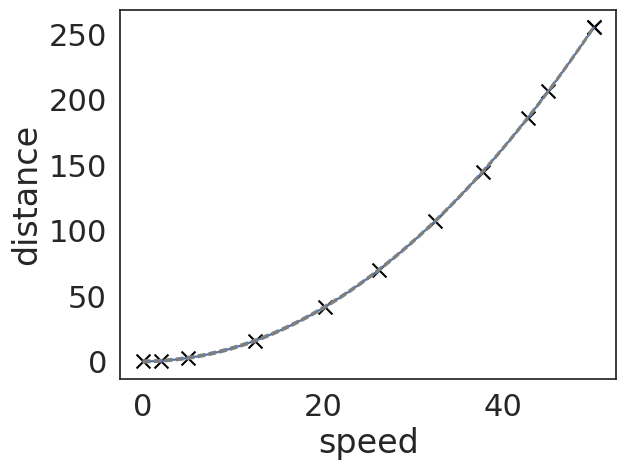

In [46]:
speeds = np.linspace(0, 50, 100)

input_data = pd.DataFrame({'speed':speeds})


output_data, output_data_std = regressor.predict_uncertainty(input_data)

data = pd.DataFrame({'speed':speeds,
                    'distance':output_data['distance'],
                    'distance_std':output_data_std['distance']})

sns.set_theme(style="white", font_scale=2)
sns.lineplot(x='speed', y='distance', data=data)
plt.scatter(x=regressor.parameters.input_data['speed'], y=regressor.parameters.output_data['distance'], color='black', marker='x', s=100)

#create two lines and fill the area between them
plt.plot(data['speed'], data['distance'] + 2*data['distance_std'], color='grey', linestyle='dashed')
plt.plot(data['speed'], data['distance'] - 2*data['distance_std'], color='grey', linestyle='dashed')
plt.fill_between(data['speed'], data['distance'] + 2*data['distance_std'], data['distance'] - 2*data['distance_std'], alpha=0.2)

## Create a launch angle visualization

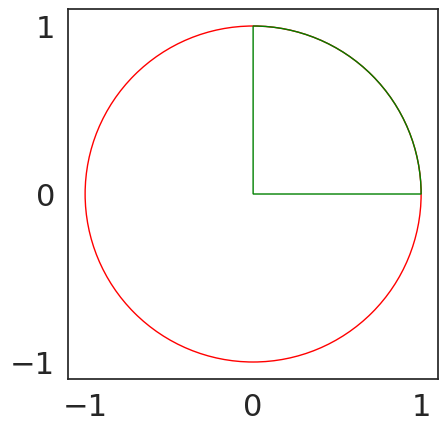

In [47]:
from matplotlib.patches import Circle, Wedge


# Create a figure and axis
fig, ax = plt.subplots()

# Create a circle with radius 1 and a red edge
circle = Circle((0, 0), 1, edgecolor='red', facecolor='none')
ax.add_patch(circle)

# Create a wedge with a green face and a red edge, from 0 to 90 degrees
wedge = Wedge((0, 0), 1, 0, 90, edgecolor='green', facecolor='none')
ax.add_patch(wedge)

# Set the axis limits and aspect ratio
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_aspect('equal')

plt.yticks([-1, 0, 1])

# Show the plot
plt.show()

## fire a single projectile

Text(0, 0.5, 'Height (m)')

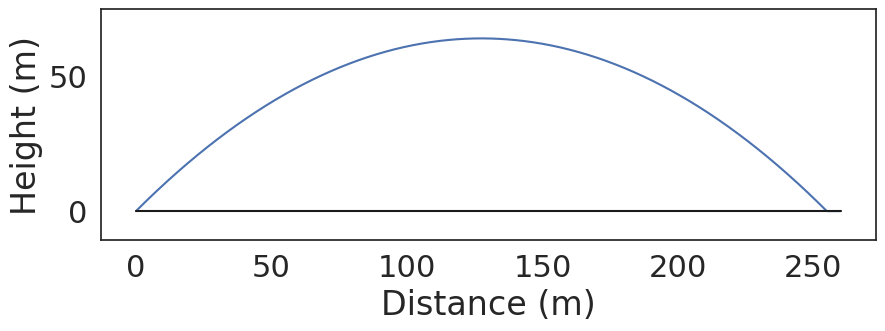

In [48]:
#Create a plot of many different launch angles and speeds

speeds = 50
launch_angles = np.pi/4


distance = np.linspace(0, 260, 1000)

height = np.tan(launch_angles) * distance - (g * distance**2) / (2 * speeds**2 * np.cos(launch_angles)**2)

height[height<0] = 0

plt.figure(figsize=[10,3])
plt.plot(distance, height)
plt.plot([0, 260], [0,0], 'k')

plt.axis('equal')
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)')

# Compare surrogate MC

Text(0.5, 0, 'Distance (m)')

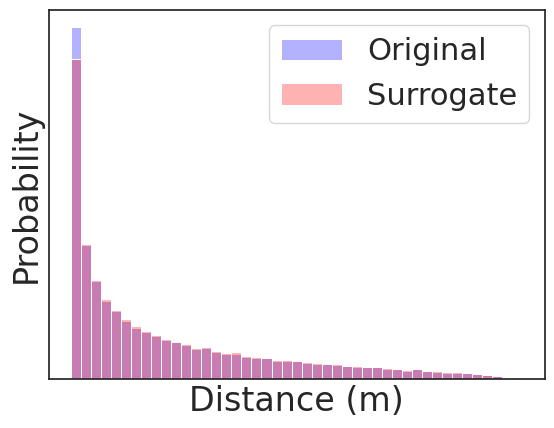

In [49]:
data = pd.DataFrame({'original':mc_app.scores['distance'], 'surrogate':mc_app_surrogate.scores['distance']})

edges = np.histogram_bin_edges(data['original'], bins="auto")

sns.histplot(data=data, x='original', stat='probability', color='blue', label='Original', bins=edges, alpha=0.3)
sns.histplot(data=data, x='surrogate', stat='probability', color='red', label='Surrogate', bins=edges, alpha=0.3)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel('Distance (m)')

Text(0.5, 0, 'Flight Time (s)')

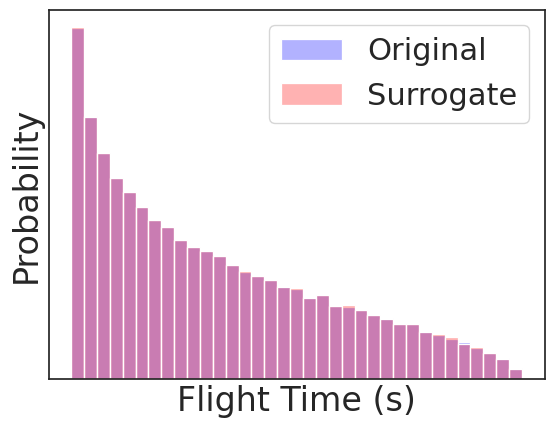

In [50]:
data = pd.DataFrame({'original':mc_app.scores['flight_time'], 'surrogate':mc_app_surrogate.scores['flight_time']})

edges = np.histogram_bin_edges(data['original'], bins="auto")

sns.histplot(data=data, x='original', stat='probability', color='blue', label='Original', bins=edges, alpha=0.3)
sns.histplot(data=data, x='surrogate', stat='probability', color='red', label='Surrogate', bins=edges, alpha=0.3)
plt.legend()
plt.xticks([])
plt.yticks([])
plt.xlabel('Flight Time (s)')

In [51]:
mc_app.scores

,distance,flight_time
0,1.001104e-07,0.000004
1,6.373226e+01,3.605241
2,1.014094e+02,2.928512
3,1.129779e+01,2.357209
4,3.314800e+01,2.125798
...,...,...
4091,4.194498e+00,3.822083
4092,1.398848e+01,1.295160
4093,6.993043e+01,7.402092
4094,1.754223e+01,0.708071
